In [1]:
import os
os.environ["THEANO_FLAGS"]="mode=FAST_RUN, device=cpu,floatX=float32"
import theano
import keras
import time

import numpy as np
import Binary_DUDE as DUDE
import Binary_N_DUDE as N_DUDE
import matplotlib.pyplot as plt
%matplotlib inline 

from numpy import *
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.optimizers import SGD, RMSprop, Adagrad, Adam, Adadelta
from keras.utils import np_utils

Using Theano backend.


In [2]:
data=np.load('/HDD/user/yoon/Yoon_SV4/N-DUDE_SV4/NeuralDUDE_Delta_Variation/Data_Generation&Save/Neural_dude_Data_lena512.npz')

z_two=data['z_two']
z=data['z']
imarray=data['imarray']
n=imarray.shape[0]*imarray.shape[1]
offset=data['offset']
L=data['L']
L_new=data['L_new']
x=data['x']
L_lower=data['L_lower']

In [69]:
### Make data which this experiment needs ###
n=imarray.shape[0]*imarray.shape[1]
alpha_size=2
mapping_size=3
nb_classes=2

Z=[]
P=np.zeros((imarray.shape[0],imarray.shape[1],nb_classes),dtype=np.int)
Z=np_utils.to_categorical(z[9],nb_classes) ## [0]->[1 0], [1]->[0 1]
P=np.reshape(Z,(imarray.shape[0], imarray.shape[1], nb_classes))

In [4]:
######## 1-D N-DUDE Context Bind ########
def make_data_for_One_NN_DUDE_Context_Bind(z,Z,k,L,nb_classes,n):
    Context=[]
    m={}
    for i in range(k,n-k):
        c_i = vstack((Z[i-k:i,],Z[i+1:i+k+1,])).reshape(1,2*k*nb_classes)
        context_str=''.join(str(e) for e in c_i)
        if not m.has_key(context_str): # Check whether the context is appeared before.
            m[context_str]=np.zeros(2,dtype=np.int) # 2 is alphabet size(binary).
            m[context_str][z[i]]=1 # z[i]=0, m[context_str][0] is counted, otherwise m[context_str][1] is counted.
            Context+=c_i.tolist() # if there is a new context, add it to the list
        else:
            m[context_str][z[i]]+=1
    key=m.keys()
    Context=np.reshape(Context, (len(Context),2*k*nb_classes))
    Y=zeros((len(Context),3))
    Y_Norm=Y.copy()
    for j in range(len(Context)):
        if m.has_key(str(Context[j])):
            Y[j]=dot(m[str(Context[j])],L)
    
    for l in range(len(Context)): # for normalization, divide the num of points that have the context
        Y_Norm[l]=Y[l]/sum(m[str(Context[l])])
        
    return Context,Y,Y_Norm,key,m

In [ ]:
# delta=0.1
Context,Y,Y_Norm,key,m=make_data_for_One_NN_DUDE_Context_Bind(z[9],Z,1,L_new[8:10],nb_classes,n)

In [ ]:
# delta=0.01
Context,Y,Y_Norm,key,m=make_data_for_One_NN_DUDE_Context_Bind(z[0],Z,1,L_new[0:2],nb_classes,n)

In [ ]:
model=Sequential()
model.add(Dense(40,input_dim=2*1*nb_classes,init='he_normal'))
model.add(Activation('relu'))
model.add(Dense(40,init='he_normal'))
model.add(Activation('relu'))
model.add(Dense(40,init='he_normal'))
model.add(Activation('relu'))
model.add(Dense(3,init='he_normal'))
model.add(Activation('softmax'))
        
rms=RMSprop(lr=0.001, rho=0.9, epsilon=1e-06,clipnorm=1.5)
adagrad=Adagrad(clipnorm=1.5)
adam=Adam()
adadelta=Adadelta()
sgd=SGD(lr=0.01,decay=1e-6,momentum=0.95, nesterov=True, clipnorm=1.0)
        
model.compile(loss='poisson', optimizer=adam)
hist=model.fit(Context,Y,nb_epoch=10,show_accuracy=True, verbose=0, validation_data=(Context, Y))

In [ ]:
print Context
print Y
print Y_Norm
print key
print m

In [5]:
######## 1-D DUDE ########
def One_DUDE(z,k,delta):
    n=len(z)
    x_hat=np.zeros(n,dtype=np.int)
    s_hat=x_hat.copy()

    th_0=2*delta*(1-delta)
    th_1=delta**2+(1-delta)**2
    
    m={}
    
    for i in range(k,n-k):
        context=z[i-k:i].tolist()+z[i+1:i+k+1].tolist()
        context_str = ''.join(str(e) for e in context)
        
        if not m.has_key(context_str):
            m[context_str]=np.zeros(2,dtype=np.int)
            m[context_str][z[i]]=1
        else:
            m[context_str][z[i]]+=1
    
    for i in range(k,n-k):
        context=z[i-k:i].tolist()+z[i+1:i+k+1].tolist()
        context_str = ''.join(str(e) for e in context)
        
        ratio = float(m[context_str][1]) / float(np.sum(m[context_str]))
        
        if ratio < th_0:
            s_hat[i]=1
        elif ratio >= th_1:
            s_hat[i]=2
        else:
            s_hat[i]=0

    return s_hat, m

In [ ]:
s,m=One_DUDE(z[9],5,0.1)

In [ ]:
th0=2*0.01*(1-0.01)
th1=0.01**2+(1-0.01)**2
print th0, th1

In [ ]:
k=[]
v=[]
s=[]

for key,value in sorted(m.items()):
    if float(value[1])/float(value[0]+value[1])<th0:
        s_hat=1
    elif float(value[1])/float(value[0]+value[1])>=th1:
        s_hat=2
    else:
        s_hat=0
    
    k=hstack((k,key))
    v=hstack((v,value))
    s=hstack((s,s_hat))
    print key, value[0], '    ',value[1],"{:10.3f}".format(float(value[1])/float(value[0]+value[1])), '      ',s_hat
print len(k)

In [ ]:
x_dude_hat=DUDE.denoise_with_s(z[9],s,5)
error_dude=DUDE.error_rate(x,x_dude_hat)
print error_dude   

In [ ]:
temp=np.reshape(v,(len(k),2)) # 2 is alphabet-size
v_new=temp.T
print v_new

In [ ]:
import csv
 
with open('./temp.csv', 'wb') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(k)
    writer.writerow(v_new[0])
    writer.writerow(v_new[1])
    writer.writerow(s) 

In [6]:
######## 1-D N-DUDE ########
def make_data_for_One_NN_DUDE(Z,k,L,nb_classes,n):
    C=zeros((n-2*k, 2*k*nb_classes))
    for i in range(k,n-k):
        c_i = vstack((Z[i-k:i,],Z[i+1:i+k+1,])).reshape(1,2*k*nb_classes)
        C[i-k,]=c_i
        
    Y=dot(Z[k:n-k,],L)    
    return C,Y

In [95]:
epoch=30
Hist_Loss=zeros((150,1))
Hist_Acc=zeros((150,1))
Error_One_NN_DUDE=zeros((150,1))

In [96]:
for k in range(1,6):
    C,Y=make_data_for_One_NN_DUDE(Z,k,L_new[8:10],nb_classes,n)
    Context,Y_sum,Y_Norm,key,m=make_data_for_One_NN_DUDE_Context_Bind(z[9],Z,k,L_new[8:10],nb_classes,n)
    model=Sequential()
    model.add(Dense(40,input_dim=2*k*nb_classes,init='he_normal'))
    model.add(Activation('relu'))
    model.add(Dense(40,init='he_normal'))
    model.add(Activation('relu'))
    model.add(Dense(40,init='he_normal'))
    model.add(Activation('relu'))
    model.add(Dense(3,init='he_normal'))
    model.add(Activation('softmax'))
        
    rms=RMSprop(lr=0.001, rho=0.9, epsilon=1e-06,clipnorm=1.5)
    adagrad=Adagrad(clipnorm=1.5)
    adam=Adam()
    adadelta=Adadelta()
    sgd=SGD(lr=0.01,decay=1e-6,momentum=0.95, nesterov=True, clipnorm=1.0)
    model.compile(loss='poisson', optimizer=adam)

    for i in range(epoch):

        hist=model.fit(C,Y,nb_epoch=1,batch_size=100,show_accuracy=True, verbose=0, validation_data=(C, Y)) # for N-DUDE
        #hist=model.fit(Context,Y_sum,nb_epoch=1,show_accuracy=True, verbose=0, validation_data=(Context, Y_sum)) # for N-DUDE Context
        Hist_Loss[i+epoch*(k-1),]=hist.history['loss']
        Hist_Acc[i+epoch*(k-1),]=hist.history['acc']
        pred_class=model.predict_classes(C, batch_size=200, verbose=0)
        s_nn_hat=hstack((zeros(k),pred_class,zeros(k)))
        x_nn_hat=N_DUDE.denoise_with_s(z[9],s_nn_hat,k)
        error_nn=N_DUDE.error_rate(x,x_nn_hat)
        Error_One_NN_DUDE[i+epoch*(k-1)]=error_nn
    pred_class=model.predict_classes(Context,verbose=0)
    pred_proba=model.predict_proba(Context,verbose=0)
    new_m={}
    for j in range(len(Context)):
        Context_str=str(Context[j])
        new_m[Context_str]=[pred_proba[j], pred_class[j]]
    v=[]
    print 'k=',k
    for key,value in sorted(new_m.items(), reverse=True):
        #s_hat=find_max_idx(value)
        v=hstack((v,value))
        print value
    

k= 1
[array([ 0.47519159,  0.34704724,  0.17776117]), 0]
[array([ 0.47531626,  0.21772218,  0.30696157]), 0]
[array([ 0.47522163,  0.21546882,  0.30930954]), 0]
[array([ 0.47496894,  0.12520288,  0.3998282 ]), 0]
k= 2
[array([ 0.47419438,  0.44744155,  0.07836409]), 0]
[array([ 0.47217619,  0.32518139,  0.20264244]), 0]
[array([ 0.47761947,  0.4300437 ,  0.09233681]), 0]
[array([ 0.47475028,  0.23717421,  0.28807551]), 0]
[array([ 0.47643253,  0.43231359,  0.09125388]), 0]
[array([ 0.47471541,  0.20639989,  0.3188847 ]), 0]
[array([ 0.47764355,  0.37755924,  0.14479721]), 0]
[array([ 0.47862425,  0.13746339,  0.38391235]), 0]
[array([ 0.47469842,  0.33347467,  0.19182691]), 0]
[array([ 0.47660634,  0.11138811,  0.41200554]), 0]
[array([ 0.47451705,  0.22056288,  0.30492008]), 0]
[array([ 0.47571877,  0.06241575,  0.46186545]), 0]
[array([ 0.47602108,  0.23835264,  0.28562629]), 0]
[array([ 0.47616625,  0.0671159 ,  0.45671785]), 0]
[array([ 0.47727117,  0.13825233,  0.38447648]), 0]
[a

In [97]:
print Hist_Loss
print ' ',Error_One_NN_DUDE

[[ 1.04964239]
 [ 1.04766862]
 [ 1.04747076]
 [ 1.04741927]
 [ 1.047382  ]
 [ 1.04734784]
 [ 1.04733833]
 [ 1.04734401]
 [ 1.04730903]
 [ 1.04732585]
 [ 1.04734312]
 [ 1.04729837]
 [ 1.04728784]
 [ 1.04730357]
 [ 1.04728729]
 [ 1.04728823]
 [ 1.0472738 ]
 [ 1.04726104]
 [ 1.04728222]
 [ 1.04725237]
 [ 1.04726095]
 [ 1.04727056]
 [ 1.0472793 ]
 [ 1.0472798 ]
 [ 1.04727187]
 [ 1.04725406]
 [ 1.04725166]
 [ 1.04726224]
 [ 1.04725865]
 [ 1.04725445]
 [ 1.00078594]
 [ 0.9994882 ]
 [ 0.99937081]
 [ 0.99932242]
 [ 0.99924366]
 [ 0.99922399]
 [ 0.99917913]
 [ 0.99921557]
 [ 0.99916629]
 [ 0.99916055]
 [ 0.99914469]
 [ 0.9991296 ]
 [ 0.99910752]
 [ 0.99913132]
 [ 0.9991148 ]
 [ 0.99911075]
 [ 0.99912749]
 [ 0.99911267]
 [ 0.99909974]
 [ 0.99910436]
 [ 0.99910032]
 [ 0.99909977]
 [ 0.99910523]
 [ 0.99909018]
 [ 0.99908714]
 [ 0.99908158]
 [ 0.99907993]
 [ 0.99910133]
 [ 0.99907717]
 [ 0.99909723]
 [ 1.00037089]
 [ 0.99882986]
 [ 0.99864951]
 [ 0.99863905]
 [ 0.99856846]
 [ 0.99854094]
 [ 0.99855

In [98]:
Hist_Loss_new=np.reshape(Hist_Loss,(5,30))

In [99]:
Error_One_NN_DUDE_new=np.reshape(Error_One_NN_DUDE,(5,30))

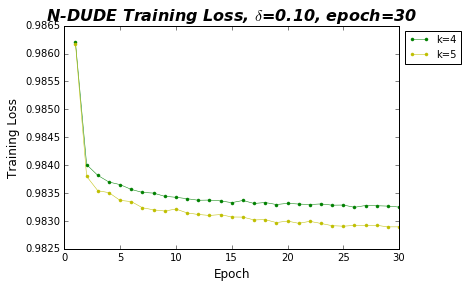

In [107]:
epoch=range(1,31)
#fig=plt.figure(k)
results=plt.subplot(111)
    
#results.plot(epoch,Hist_Loss_new[0],'k-',marker='.',linewidth=0.5)
#results.plot(epoch,Hist_Loss_new[1],'r-',marker='.',linewidth=0.5)
#results.plot(epoch,Hist_Loss_new[2],'b-',marker='.',linewidth=0.5)
results.plot(epoch,Hist_Loss_new[3],'g-',marker='.',linewidth=0.5)
results.plot(epoch,Hist_Loss_new[4],'y-',marker='.',linewidth=0.5)

plt.legend(['k=4','k=5','k=3','k=4','k=5'],fontsize=10,bbox_to_anchor=(1.2, 1.0))
#plt.ylim((0.3,1.1))
plt.title('N-DUDE Training Loss, $\delta$=%0.2f, epoch=30'% 0.1, fontweight='bold', fontstyle='italic', fontsize=16, horizontalalignment='center')

plt.xlabel('Epoch',fontsize=12)
plt.ylabel('Training Loss',fontsize=12)
    
#minimum_idx_One_DUDE=fd.find_min_idx(Error_One_DUDE[i])
#minimum_idx_One_NN_DUDE=fd.find_min_idx(Error_One_NN_DUDE[i])
#minimum_idx_One_NN_DUDE_Bind=fd.find_min_idx(Error_One_NN_DUDE_Bind[i])
    
#min_One_DUDE=(min(Error_One_DUDE[i]))/delta[i]
#min_One_NN_DUDE=(min(Error_One_NN_DUDE[i]))/delta[i]
#min_One_NN_DUDE_Bind=(min(Error_One_NN_DUDE_Bind[i]))/delta[i]
    
#plt.annotate('%0.3f$\delta$, k=%d' %(round(min_One_DUDE,3),minimum_idx_One_DUDE), xy=(minimum_idx_One_DUDE, round(min_One_DUDE,3)), 
#             xytext=(minimum_idx_One_DUDE-4, round(min_One_DUDE,3)-0.2),
#             arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=90,rad=10",color='k',linewidth=1.5),color='k',weight='bold')
    
#plt.annotate('%0.3f$\delta$, k=%d' %(round(min_One_NN_DUDE,3),minimum_idx_One_NN_DUDE), xy=(minimum_idx_One_NN_DUDE, round(min_One_NN_DUDE,3)), 
#             xytext=(minimum_idx_One_NN_DUDE-4, round(min_One_NN_DUDE,3)-0.18),
#             arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=90,rad=10",color='r',linewidth=1.5),color='r',weight='bold')
    
#plt.annotate('%0.3f$\delta$, k=%d' %(round(min_One_NN_DUDE_Bind,3),minimum_idx_One_NN_DUDE_Bind), xy=(minimum_idx_One_NN_DUDE_Bind, round(min_One_NN_DUDE_Bind,3)), 
#             xytext=(minimum_idx_One_NN_DUDE_Bind-4, round(min_One_NN_DUDE_Bind,3)-0.18),
#             arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=90,rad=10",color='r',linewidth=1.5),color='r',weight='bold')
    
plt.savefig('/HDD/user/yoon/Yoon_SV4/N-DUDE_SV4/NeuralDUDE_Delta_Variation/Results/Trainingloss_k=4&5_Delta=%0.2f.pdf'%0.1,bbox_inches='tight')

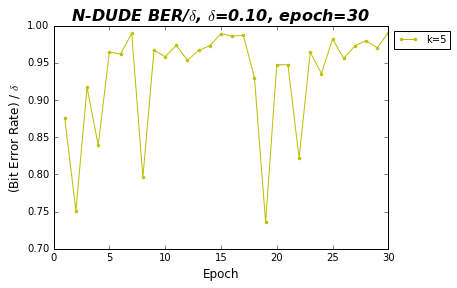

In [113]:
epoch=range(1,31)
#fig=plt.figure(k)
results=plt.subplot(111)
    
#results.plot(epoch,Error_One_NN_DUDE_new[0]/0.1,'k-',marker='.',linewidth=1.0)
#results.plot(epoch,Error_One_NN_DUDE_new[1]/0.1,'r-',marker='.',linewidth=1.0)
#results.plot(epoch,Error_One_NN_DUDE_new[2]/0.1,'b-',marker='.',linewidth=1.0)
#results.plot(epoch,Error_One_NN_DUDE_new[3]/0.1,'g-',marker='.',linewidth=1.0)
results.plot(epoch,Error_One_NN_DUDE_new[4]/0.1,'y-',marker='.',linewidth=1.0)

plt.legend(['k=5','k=2','k=3','k=4','k=5'],fontsize=10,bbox_to_anchor=(1.2, 1.0))
#plt.ylim((0.5,1.5))
plt.title('N-DUDE BER/$\delta$, $\delta$=%0.2f, epoch=30'% 0.1, fontweight='bold', fontstyle='italic', fontsize=16, horizontalalignment='center')

plt.xlabel('Epoch',fontsize=12)
plt.ylabel('(Bit Error Rate) / $\delta$',fontsize=12)
    
#minimum_idx_One_DUDE=fd.find_min_idx(Error_One_DUDE[i])
#minimum_idx_One_NN_DUDE=fd.find_min_idx(Error_One_NN_DUDE[i])
#minimum_idx_One_NN_DUDE_Bind=fd.find_min_idx(Error_One_NN_DUDE_Bind[i])
    
#min_One_DUDE=(min(Error_One_DUDE[i]))/delta[i]
#min_One_NN_DUDE=(min(Error_One_NN_DUDE[i]))/delta[i]
#min_One_NN_DUDE_Bind=(min(Error_One_NN_DUDE_Bind[i]))/delta[i]
    
#plt.annotate('%0.3f$\delta$, k=%d' %(round(min_One_DUDE,3),minimum_idx_One_DUDE), xy=(minimum_idx_One_DUDE, round(min_One_DUDE,3)), 
#             xytext=(minimum_idx_One_DUDE-4, round(min_One_DUDE,3)-0.2),
#             arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=90,rad=10",color='k',linewidth=1.5),color='k',weight='bold')
    
#plt.annotate('%0.3f$\delta$, k=%d' %(round(min_One_NN_DUDE,3),minimum_idx_One_NN_DUDE), xy=(minimum_idx_One_NN_DUDE, round(min_One_NN_DUDE,3)), 
#             xytext=(minimum_idx_One_NN_DUDE-4, round(min_One_NN_DUDE,3)-0.18),
#             arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=90,rad=10",color='r',linewidth=1.5),color='r',weight='bold')
    
#plt.annotate('%0.3f$\delta$, k=%d' %(round(min_One_NN_DUDE_Bind,3),minimum_idx_One_NN_DUDE_Bind), xy=(minimum_idx_One_NN_DUDE_Bind, round(min_One_NN_DUDE_Bind,3)), 
#             xytext=(minimum_idx_One_NN_DUDE_Bind-4, round(min_One_NN_DUDE_Bind,3)-0.18),
#             arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=90,rad=10",color='r',linewidth=1.5),color='r',weight='bold')
    
plt.savefig('/HDD/user/yoon/Yoon_SV4/N-DUDE_SV4/NeuralDUDE_Delta_Variation/Results/BER_k=5_Delta=%0.2f.pdf'%0.1,bbox_inches='tight')

In [ ]:
def find_max_idx(a):
    maximum=max(a)
    for i in range(len(a)):
        if a[i]==maximum:
            maximum_idx=i
    return maximum_idx